In [1]:
import itertools as it
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import DataLoader, TensorDataset, random_split
import attention as att
import torch.optim as optim
from tqdm import trange
from matplotlib.colors import LogNorm
import pandas as pd

In [2]:
# For same initialization of weights/biases of model
torch.manual_seed(seed=999)
torch.set_float32_matmul_precision('high')

In [3]:
input_CG = np.load('/pscratch/sd/h/hbassi/GS_model_multi_traj_data_coarse_scale_dynamics.npy')
target_FG = np.load('/pscratch/sd/h/hbassi/GS_model_multi_traj_data_fine_scale_dynamics.npy') 
#input_CG = np.load('/pscratch/sd/h/hbassi/GS_model_data_coarse_scale_dynamics.npy')
#target_FG = np.load('/pscratch/sd/h/hbassi/GS_model_data_fine_scale_dynamics.npy')
num_trajectories = 87
time_steps = 400
input_CG = input_CG.reshape((num_trajectories, time_steps, 1, 48, 48))
target_FG = target_FG.reshape((num_trajectories, time_steps, 1, 128, 128))
input_CG.shape, target_FG.shape

((87, 400, 1, 48, 48), (87, 400, 1, 128, 128))

In [4]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # Reduces size from 48x48 to 24x24
        )

        # Middle
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # Upsample from 12x12 to 24x24
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up2 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # Upsample from 24x24 to 48x48
        self.dec2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # Upsample from 48x48 to 96x96
        self.dec3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        enc = self.encoder(x)
        mid = self.middle(enc)
        up1 = self.up1(mid)
        dec1 = self.dec1(up1)
        up2 = self.up2(dec1)
        dec2 = self.dec2(up2)
        up3 = self.up3(dec2)
        dec3 = self.dec3(up3)
        # Crop or pad the output tensor to match the target size (128x128)
        return dec3[:, :, :128, :128]  # Ensure the final output is 128x128
unet = UNet()

In [5]:
device = 'cpu'
input_CG_tensor = torch.tensor(input_CG, dtype=torch.float32).to(device)
target_FG_tensor = torch.tensor(target_FG, dtype=torch.float32).to(device)

In [6]:
unet = torch.compile(unet)

In [7]:
#unet.load_state_dict(torch.load('/pscratch/sd/h/hbassi/unet_epoch_14000_GS_multi_traj.pth'))
#unet.load_state_dict(torch.load('/pscratch/sd/h/hbassi/unet_epoch_29900_GS_single_traj_training.pth'))
unet.load_state_dict(torch.load('/pscratch/sd/h/hbassi/unet_epoch_29900_GS_multi_traj_training.pth'))

<All keys matched successfully>

In [8]:
unet.eval().cpu()

OptimizedModule(
  (_orig_mod): UNet(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (middle): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (up1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (dec1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (up2): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (dec2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3)

In [27]:
#[0,35, 64]
test_idx = 70

In [28]:
inputs = input_CG[test_idx]
predictions = unet(torch.Tensor(inputs).float()).detach().numpy()
targets = target_FG[test_idx]

In [29]:
predictions.shape, targets.shape, inputs.shape

((400, 1, 128, 128), (400, 1, 128, 128), (400, 1, 48, 48))

In [30]:
# input_CG_test_tensor = input_CG[test_idx]
# target_FG_test_tensor = target_FG[test_idx]

In [31]:
# input_CG_test_tensor.shape

In [32]:
# predictions = []
# targets = []
# inputs = []  
# with torch.no_grad():
 
#     batch_size = 64
#     for i in range(0, input_CG_test_tensor.shape[0], batch_size):
#         data = input_CG_test_tensor[i:i + batch_size]
#         target = target_FG_test_tensor[i:i + batch_size]

       
#         #print(f"Batch Data shape: {data.shape}, Target shape: {target.shape}")

#         output = unet(torch.Tensor(data).float())  
     
#         #print(f"Output shape before reshaping: {output.shape}")

#         #output = output.view(output.shape[0], 1, output_dim, output_dim)  

       
#         predictions.append(output.numpy())
#         targets.append(target)
#         inputs.append(data)  
 

In [33]:
# # Convert predictions, targets, and inputs to numpy arrays
# predictions = np.concatenate(predictions, axis=0)  
# targets = np.concatenate(targets, axis=0)  
# inputs = np.concatenate(inputs, axis=0)  

In [34]:
# predictions.shape, targets.shape, inputs.shape

Sample 1 - MAE (Prediction vs Target): 0.0019
Sample 2 - MAE (Prediction vs Target): 0.0007
Sample 3 - MAE (Prediction vs Target): 0.0005
Sample 4 - MAE (Prediction vs Target): 0.0004


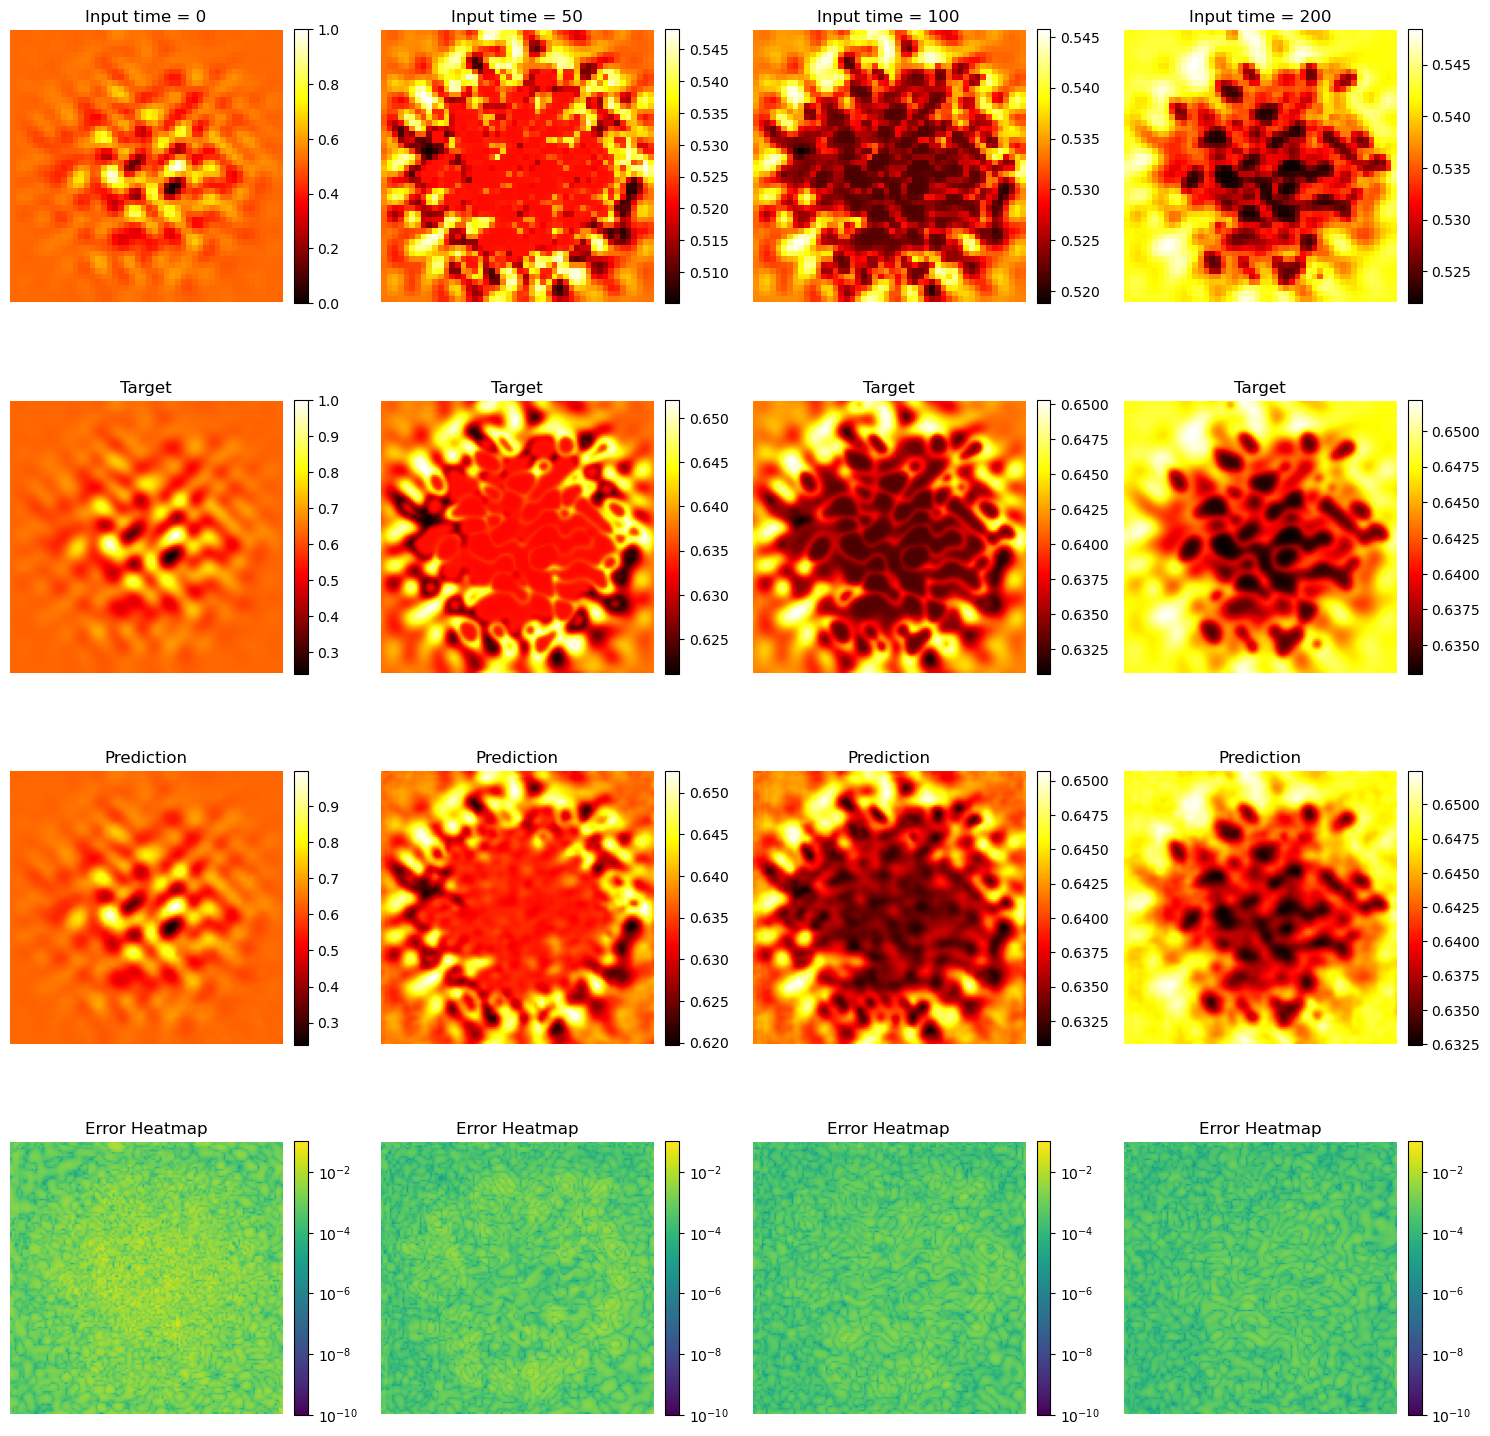

In [35]:
# Example input data dimensions
traj_idx = 0  # Number of samples to visualize
num_samples = 4
indices = [0, 50, 100, 200]
plt.figure(figsize=(15, 15))  # Adjusted figure size for additional row

for i, idx in enumerate(indices):
    # Plot the input
    ax = plt.subplot(4, num_samples, i + 1)
    im = ax.imshow(inputs[idx, 0], cmap='hot')  # Use the first channel
    plt.title('Input time = ' +str( idx))
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for input

    # Plot the target
    ax = plt.subplot(4, num_samples, i + 1 + num_samples)
    im = ax.imshow(targets[idx, 0], cmap='hot')  # Use the first channel
    plt.title('Target')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for target

    # Plot the prediction
    ax = plt.subplot(4, num_samples, i + 1 + 2 * num_samples)
    im = ax.imshow(predictions[idx, 0], cmap='hot')  # Use the first channel
    plt.title('Prediction')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for prediction

    # Calculate the error and plot the error heatmap with color bar
    error = np.abs(predictions[idx, 0] - targets[idx, 0])
    ax = plt.subplot(4, num_samples, i + 1 + 3 * num_samples)
    im = ax.imshow(error, cmap='viridis', norm=LogNorm(vmin=1e-10, vmax=1e-1))  # Error heatmap
    plt.title('Error Heatmap')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for error heatmap

     # Compute and print MAE for prediction vs target
    mae_prediction_target = np.mean(error)
    print(f"Sample {i+1} - MAE (Prediction vs Target): {mae_prediction_target:.4f}")
    
plt.tight_layout()
#plt.savefig('./figures/unet_GS_model_training_result_multi_traj_dataset_multiple_randomized1.png')

In [17]:
# # Path to the log file
# log_file_path = './logs/training_log.txt'

# # Read the log file into a pandas dataframe
# df = pd.read_csv(log_file_path)

# # Plot the losses
# plt.figure(figsize=(10, 6))

# # Plot training and validation loss
# plt.plot(df['Epoch'], df['Training Loss'], label='Training Loss')
# plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss')

# # Adding labels and title
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss over Epochs')
# plt.legend()